In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [2]:
orders = pd.read_csv(
    "../data/part1-dataset.csv", parse_dates=["created_date", "first_created_at"]
    )

In [3]:
orders.head(10)

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,source_latitude,source_longitude,destination_latitude,destination_longitude,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack
0,2022-07-25,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,30.604658,53.503632,31.602938,54.477932,300000,300000,250000,1
1,2022-07-23,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,37.306400,60.657444,38.305122,61.677757,470000,470000,230000,1
2,2022-10-16,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,33.629711,52.633621,34.628998,53.630806,160000,160000,160000,1
3,2022-10-25,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,33.672604,52.686855,34.654903,53.704929,950000,530000,530000,1
4,2022-08-01,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,36.820545,51.996281,37.827084,52.974762,450000,360000,230000,1
5,2022-08-02,0,2,2022-08-02 12:26:30+00:00,101,2.3040,3,31.273190,58.074833,32.285353,59.085854,270000,270000,270000,1
6,2022-08-21,0,7,2022-08-21 15:48:34+00:00,121,1.3930,4,37.561237,54.072170,38.556301,55.076195,400000,180000,180000,0
7,2022-09-08,0,4,2022-09-08 08:29:30+00:00,77,1.4002,4,37.361897,60.506786,38.355972,61.503471,170000,170000,170000,1
8,2022-11-11,0,5,2022-11-11 17:38:51+00:00,126,1.4832,10,37.372936,60.477482,38.368992,61.470581,340000,170000,170000,0
9,2022-10-17,0,1,2022-10-17 09:25:59+00:00,77,4.4246,2,35.624802,51.876247,36.643002,52.876999,360000,270000,240000,0


## Exploratory Data Analysis

In [4]:
orders = orders.assign(first_created_at_hour = orders["first_created_at"].dt.hour)

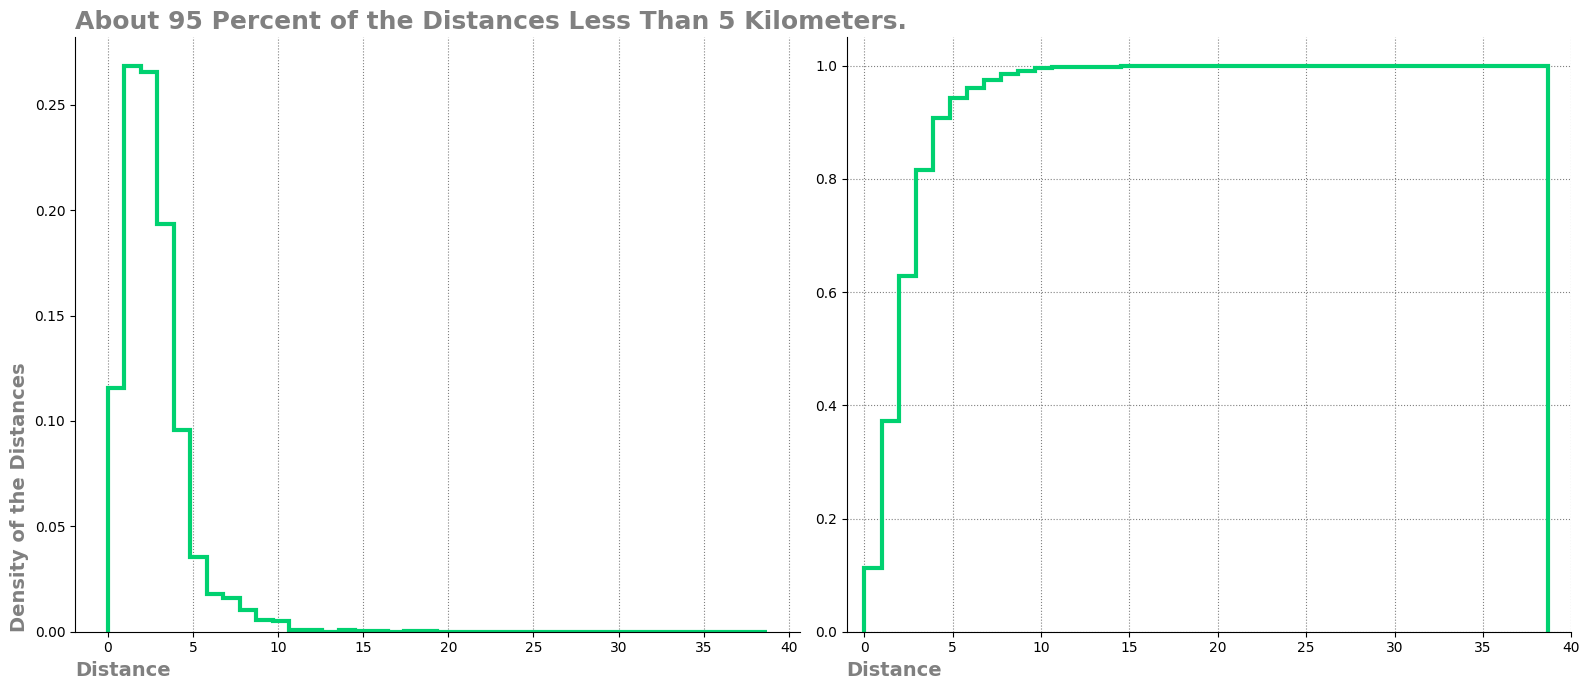

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].hist(
    orders['total_distance'],
    color = "#00D170",
    bins = 40,
    density = True,
    histtype = "step",
    lw = 3,
)

ax[0].spines[["right", "top"]].set_visible(False)
ax[0].set_ylabel(
    "Density of the Distances",
    loc = "bottom",
    weight = "bold",
    fontsize = 14,
    color = "gray"
)
ax[0].set_xlabel("Distance", loc = "left", weight = "bold",fontsize = 14, color = "gray")
ax[0].set_title(
    "About 95 Percent of the Distances Less Than 5 Kilometers.",
    weight = "bold",
    color = "gray",
    fontsize = 18,
    loc = "left"
)
ax[0].grid(True, which='major', axis='x', linestyle=':', color='gray')

ax[1].hist(
    orders["total_distance"],
    color="#00D170",
    bins=40,
    density=True,
    cumulative=True,
    histtype="step",
    lw=3,
)

ax[1].spines[["right", "top"]].set_visible(False)

ax[1].set_xlabel("Distance", loc="left", weight="bold", fontsize=14, color="gray")

ax[1].set_ylim(0, 1.05)
ax[1].set_xlim(-1, 40)  

ax[1].grid(True, which='major', axis='both', linestyle=':', color='gray')

plt.tight_layout()
plt.show()

In [6]:
normal_hyper_ack_status = (
    orders.groupby(['first_created_at_hour', 'hyper_ack'], as_index=False)
    .agg(
        total_order = ('hyper_ack', 'count'),
    )
    .pivot_table(
        index = "first_created_at_hour", columns= "hyper_ack", values="total_order"
    )
    .reset_index()
    .rename(columns={0: "normal", 1: "hyper_ack"})
    .fillna(0)
    .assign(total_hour_order=lambda df: df['normal'] + df['hyper_ack'])
    .assign(share_hyper_ack= lambda df: df['hyper_ack'] / df['total_hour_order'])
    .query("total_hour_order != 1")
)

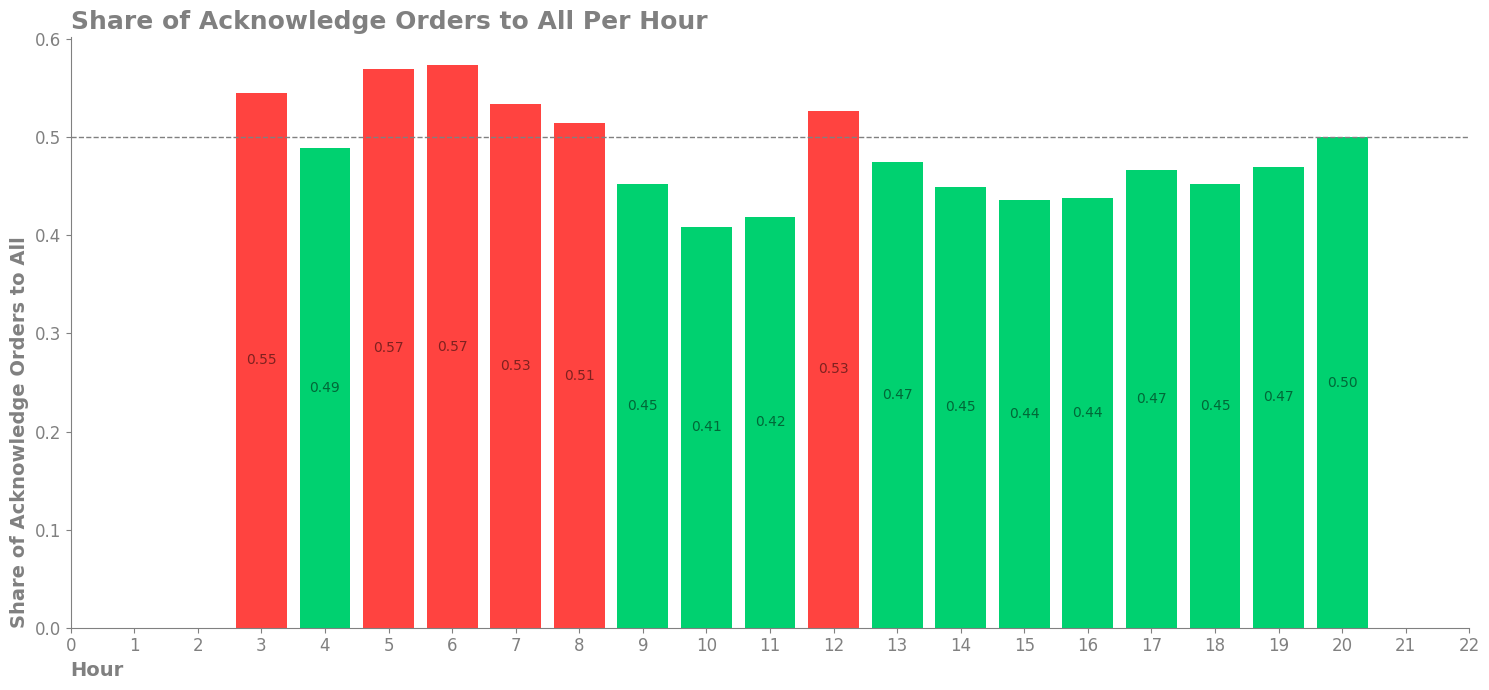

In [7]:
fig, ax = plt.subplots(figsize= (15, 7), sharex=True)

rect_share = ax.bar(
    normal_hyper_ack_status["first_created_at_hour"],
    normal_hyper_ack_status["share_hyper_ack"],
    color = np.where(
        normal_hyper_ack_status["share_hyper_ack"].gt(0.5), "#FF4340", "#00D170"
    )
)
ax.bar_label(rect_share, label_type = "center", fmt = "%.2f", alpha= 0.5)
ax.set_xticks(range(0, 23))
ax.spines[["top", "right"]].set_visible(False)   
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(axis="x", colors="gray", labelsize="large")
ax.tick_params(axis="y", colors="gray", labelsize="large")

ax.set_xlabel("Hour", loc= "left", weight="bold", fontsize = 14, color= "gray")

ax.set_ylabel(
    "Share of Acknowledge Orders to All",
    loc = "bottom",
    weight= "bold",
    fontsize =14,
    color= "gray"
)
ax.axhline(y=0.5, color= "gray", linestyle= "--", linewidth = 1)

ax.set_title(
    "Share of Acknowledge Orders to All Per Hour",
    loc = "left",
    weight= "bold",
    fontsize =18,
    color= "gray"
)

plt.tight_layout()
plt.show()


In [8]:
daily_orders = (
    orders.groupby(['created_date'], as_index=False)
    .agg(daily_order=('created_date', 'count'))
    .set_index('created_date')
    .iloc[:-1]
)


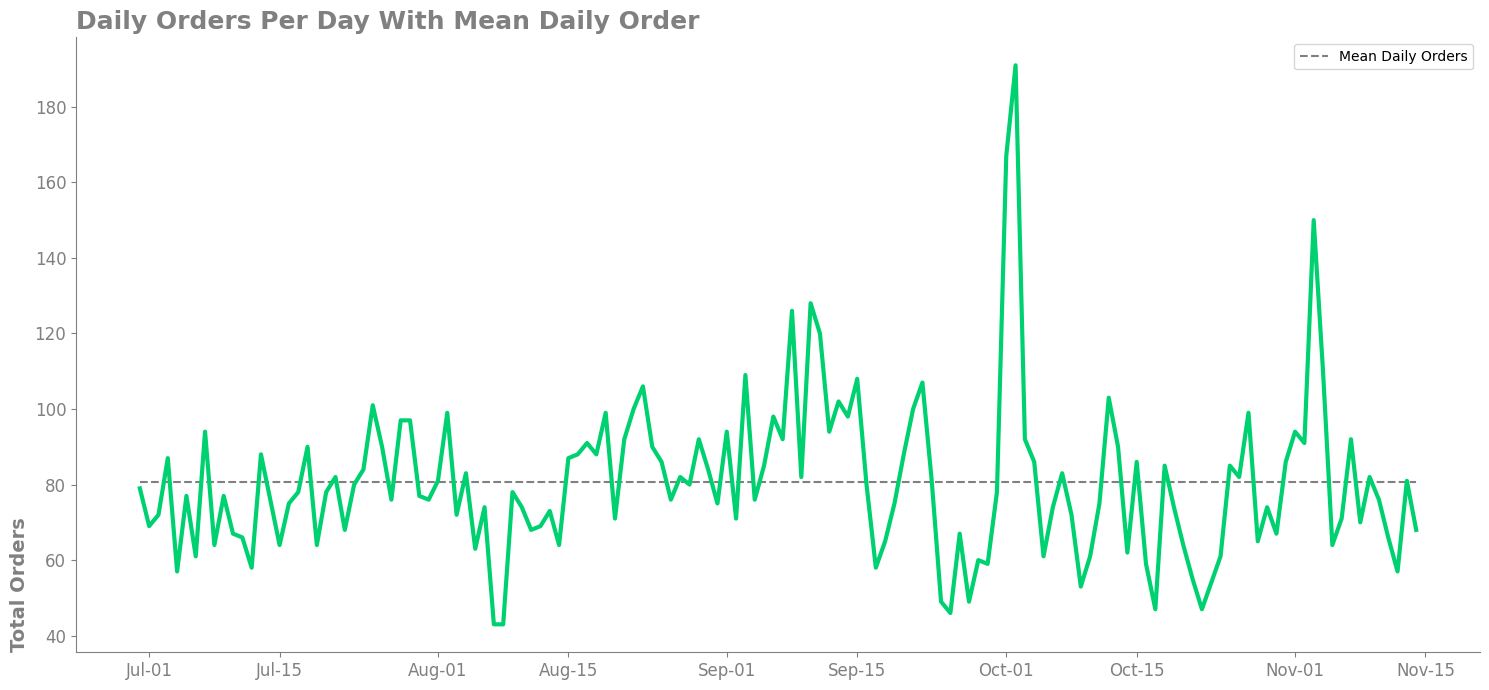

In [9]:

fig, ax= plt.subplots(figsize=(15, 7))
ax.hlines(
    daily_orders["daily_order"].mean(),
    xmin= daily_orders.index.min(),
    xmax= daily_orders.index.max(),
    linestyle= "dashed",
    color= "gray",
    label= "Mean Daily Orders"
)
ax.plot(daily_orders, lw= 3, color= "#00D170")
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["left", "bottom"]].set_color("gray")
ax.tick_params(axis="x", colors="gray", labelsize="large")
ax.tick_params(axis="y", colors="gray", labelsize="large")

ax.set_ylabel(
    "Total Orders",
    loc = "bottom",
    weight= "bold",
    fontsize =14,
    color= "gray"
)

ax.set_title(
    "Daily Orders Per Day With Mean Daily Order",
    loc = "left",
    weight= "bold",
    fontsize =18,
    color= "gray"
)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

plt.legend()
plt.tight_layout()
plt.show()


In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [11]:
destination_geo_locations = orders[['destination_latitude', 'destination_longitude']]
source_geo_locations = orders[['source_latitude', 'source_longitude']]

In [12]:
n_clusters = 1

clustering_pipeline = Pipeline(
    [
        ("preprocessor", StandardScaler()),
        (
            "clusterer",
            KMeans(
                n_clusters= n_clusters,
                init= "k-means++",
                n_init= 50,
                max_iter= 500,
                random_state= 42
            ),
        ),
    ]
)

In [13]:
source_sum_of_squared_distances =(
    []
)
for cluster in range(1, 11):
    kmeans_model = clustering_pipeline.set_params(clusterer__n_clusters = cluster)
    estimator= clustering_pipeline.fit(source_geo_locations)
    source_sum_of_squared_distances.append(kmeans_model["clusterer"].inertia_)

c:\Users\Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Ali\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Ali\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ali\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:

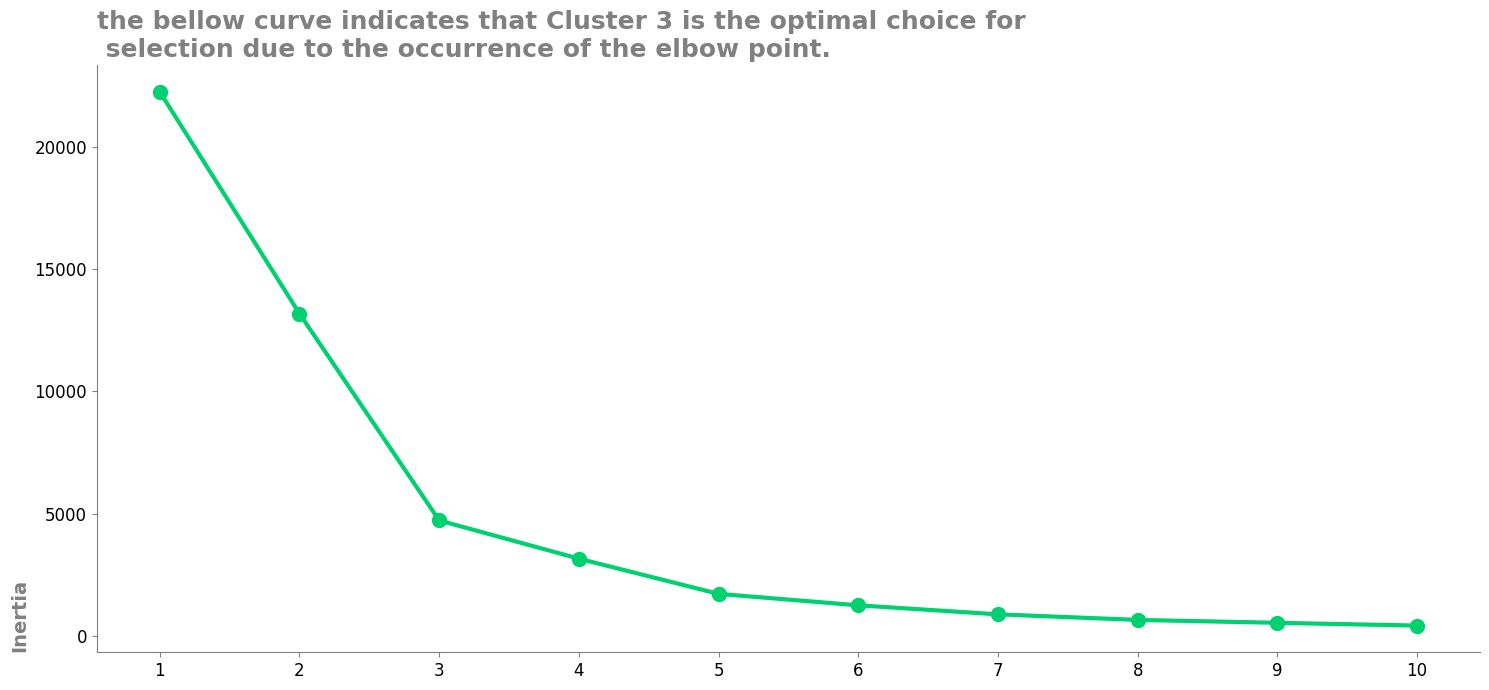

In [14]:
fig, ax= plt.subplots(figsize=(15, 7))

ax.plot(
    range(1, 11),
    source_sum_of_squared_distances,
    marker = "o",
    color = "#00D170",
    lw = 3,
    ms = 10
)

ax.set_xticks(range(1, 11))
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(axis="x", color= "gray", labelsize= "large")
ax.tick_params(axis="y", color= "gray", labelsize= "large")

ax.set_ylabel(
    "Inertia",
    loc = "bottom",
    weight= "bold",
    fontsize =14,
    color= "gray"
)

ax.set_title(
    "the bellow curve indicates that Cluster 3 is the optimal choice for\n selection due to the occurrence of the elbow point.",
    loc = "left",
    weight= "bold",
    fontsize =18,
    color= "gray"
)

plt.tight_layout()
plt.show()

In [15]:
kmeans_model = clustering_pipeline.set_params(clusterer__n_clusters = 3)
source_estimator= clustering_pipeline.fit(source_geo_locations)
labels = clustering_pipeline.predict(source_geo_locations)
source_labels = pd.Series(labels, name="source_cluster")


In [16]:
import joblib
joblib.dump(source_estimator, 
            "D:\Data Science (bootcamp)\machine_learning\guided_project_machine_learning\order-delay-analysis\model\clustering_source_location.joblib"
            )

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Ali\AppData\Local\Temp\ipykernel_11776\3491117047.py:3: SyntaxWarning: invalid escape sequence '\D'
  "D:\Data Science (bootcamp)\machine_learning\guided_project_machine_learning\order-delay-analysis\model\clustering_source_location.joblib"


['D:\\Data Science (bootcamp)\\machine_learning\\guided_project_machine_learning\\order-delay-analysis\\model\\clustering_source_location.joblib']

In [17]:
destination_sum_of_squared_distances =(
    []
)
for cluster in range(1, 11):
    kmeans_model = clustering_pipeline.set_params(clusterer__n_clusters = cluster)
    estimator= clustering_pipeline.fit(destination_geo_locations)
    destination_sum_of_squared_distances.append(kmeans_model["clusterer"].inertia_)

In [18]:
kmeans_model = clustering_pipeline.set_params(clusterer__n_clusters = 3)
destination_estimator= clustering_pipeline.fit(destination_geo_locations)
labels = clustering_pipeline.predict(destination_geo_locations)
destination_labels = pd.Series(labels, name="destination_cluster")

In [19]:
import joblib
joblib.dump(destination_estimator, 
            "D:\Data Science (bootcamp)\machine_learning\guided_project_machine_learning\order-delay-analysis\model\clustering_destination_location.joblib"
            )

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Ali\AppData\Local\Temp\ipykernel_11776\3642958381.py:3: SyntaxWarning: invalid escape sequence '\D'
  "D:\Data Science (bootcamp)\machine_learning\guided_project_machine_learning\order-delay-analysis\model\clustering_destination_location.joblib"


['D:\\Data Science (bootcamp)\\machine_learning\\guided_project_machine_learning\\order-delay-analysis\\model\\clustering_destination_location.joblib']

In [20]:
orders_features = pd.concat(
    [orders, destination_labels, source_labels], axis='columns'
).drop(
    columns=[
        'source_latitude',
        'source_longitude',
        'destination_latitude',
        'destination_longitude'
    ]
)

In [21]:
orders_features.head()

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack,first_created_at_hour,destination_cluster,source_cluster
0,2022-07-25,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,300000,300000,250000,1,15,1,2
1,2022-07-23,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,470000,470000,230000,1,10,2,1
2,2022-10-16,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,160000,160000,160000,1,10,1,2
3,2022-10-25,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,950000,530000,530000,1,9,1,2
4,2022-08-01,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,450000,360000,230000,1,8,0,0


## Feature Analysis

In [22]:
CORRELATION_COLUMNS = [
    "weekday",
    "time_bucket",
    "total_distance",
    "sum_product",
    "source_cluster",
    "destination_cluster",
    "final_customer_fare",
    "final_biker_fare",
    "first_customer_fare",
    "hyper_ack"
]

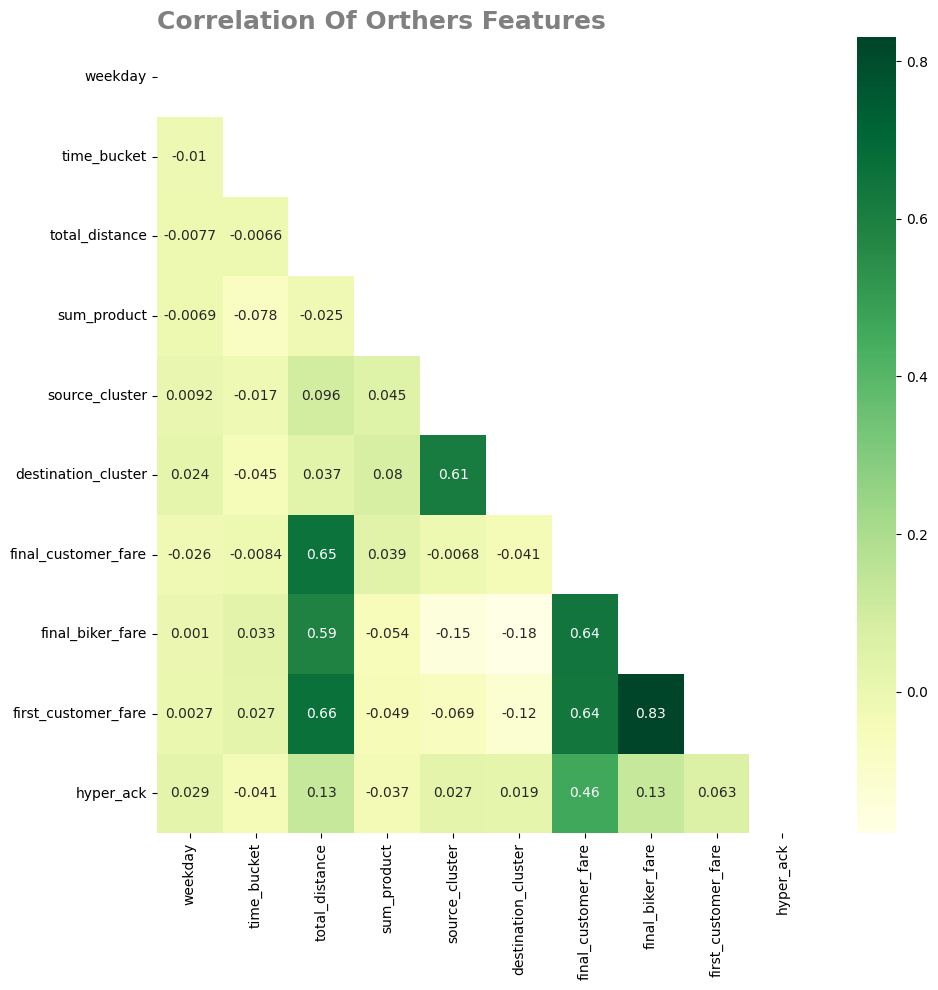

In [23]:
fig, ax= plt.subplots(figsize=(10, 10))
matrix = np.triu(orders_features[CORRELATION_COLUMNS].corr())
ax = sns.heatmap(
    orders_features[CORRELATION_COLUMNS].corr(), cmap="YlGn", annot=True, mask=matrix
)

ax.set_title(
    "Correlation Of Orthers Features",
    weight = "bold",
    loc = "left",
    color = "gray",
    fontsize = 18
)

plt.tight_layout()
plt.show()

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf

In [25]:
orders_features.head()

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack,first_created_at_hour,destination_cluster,source_cluster
0,2022-07-25,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,300000,300000,250000,1,15,1,2
1,2022-07-23,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,470000,470000,230000,1,10,2,1
2,2022-10-16,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,160000,160000,160000,1,10,1,2
3,2022-10-25,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,950000,530000,530000,1,9,1,2
4,2022-08-01,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,450000,360000,230000,1,8,0,0


In [26]:
orders_features_analysis = orders_features.assign(
    sum_product = (pd.qcut(orders["sum_product"], q=4, labels=range(1, 5)))
)

In [27]:
log_reg = smf.logit(
    "hyper_ack ~ C(weekday) + \
        C(deliverey_category_id) + \
            time_bucket + \
                total_distance + \
                    C(sum_product) + \
                        final_customer_fare + \
                            source_cluster + \
                                destination_cluster + \
                                    first_created_at_hour",
    data = orders_features_analysis,
).fit()

Optimization terminated successfully.
         Current function value: 0.344299
         Iterations 7


In [28]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              hyper_ack   No. Observations:                11107
Model:                          Logit   Df Residuals:                    11089
Method:                           MLE   Df Model:                           17
Date:                Wed, 20 Aug 2025   Pseudo R-squ.:                  0.5017
Time:                        12:26:26   Log-Likelihood:                -3824.1
converged:                       True   LL-Null:                       -7674.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -1.9098      0.196     -9.769      0.000      -2.293      -1.527
C(weekday)[T.2]                  -0.1259      0.113     -1.111      0.267      -0.348       0.096
C(weekday)[T.3]                  -0.0318      0.113     -0.281      0.779      -0.253       0.190
C(weekday)[T.4]                  -0.2180      0.110     -1.982      0.047      -0.434      -0.002
C(weekday)[T.5]                   0.0286      0.113      0.253      0.800      -0.193       0.251
C(weekday)[T.6]                   0.5017      0.109      4.587      0.000       0.287       0.716
C(weekday)[T.7]                   0.5597      0.109      5.145      0.000       0.346       0.773
C(deliverey_category_id)[T.1]     0.9140      0.586      1.560      0.119      -0.234       2.062
C(deliverey_category_id)[T.4]     4.2160      0.095     44.541      0.000       4.030       4.402
C(sum_product)[T.2]              -0.3653      0.082     -4.443      0.000      -0.526      -0.204
C(sum_product)[T.3]              -0.1684      0.096     -1.754      0.079      -0.357       0.020
C(sum_product)[T.4]              -0.4949      0.077     -6.400      0.000      -0.646      -0.343
time_bucket                      -0.0075      0.004     -1.805      0.071      -0.016       0.001
total_distance                   -0.2775      0.021    -13.029      0.000      -0.319      -0.236
final_customer_fare            6.398e-06   2.38e-07     26.901      0.000    5.93e-06    6.86e-06
source_cluster                   -0.1192      0.047     -2.557      0.011      -0.211      -0.028
destination_cluster              -0.3788      0.062     -6.063      0.000      -0.501      -0.256
first_created_at_hour             0.0221      0.025      0.879      0.379      -0.027       0.071
=================================================================================================
"""

In [29]:
odds_ratios = pd.DataFrame(
    {
        "lower_confidence_interval": log_reg.conf_int()[0],
        "odds_ratio": log_reg.params,
        "upper_confidence_interval": log_reg.conf_int()[1],
    }
)

odds_ratios = np.exp(odds_ratios)

<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Ali\AppData\Local\Temp\ipykernel_11776\523031189.py:35: SyntaxWarning: invalid escape sequence '\D'
  "D:\Data Science (bootcamp)\machine_learning\guided_project_machine_learning\order-delay-analysis/figure_pic/16_logistic_regression_analysis.png",


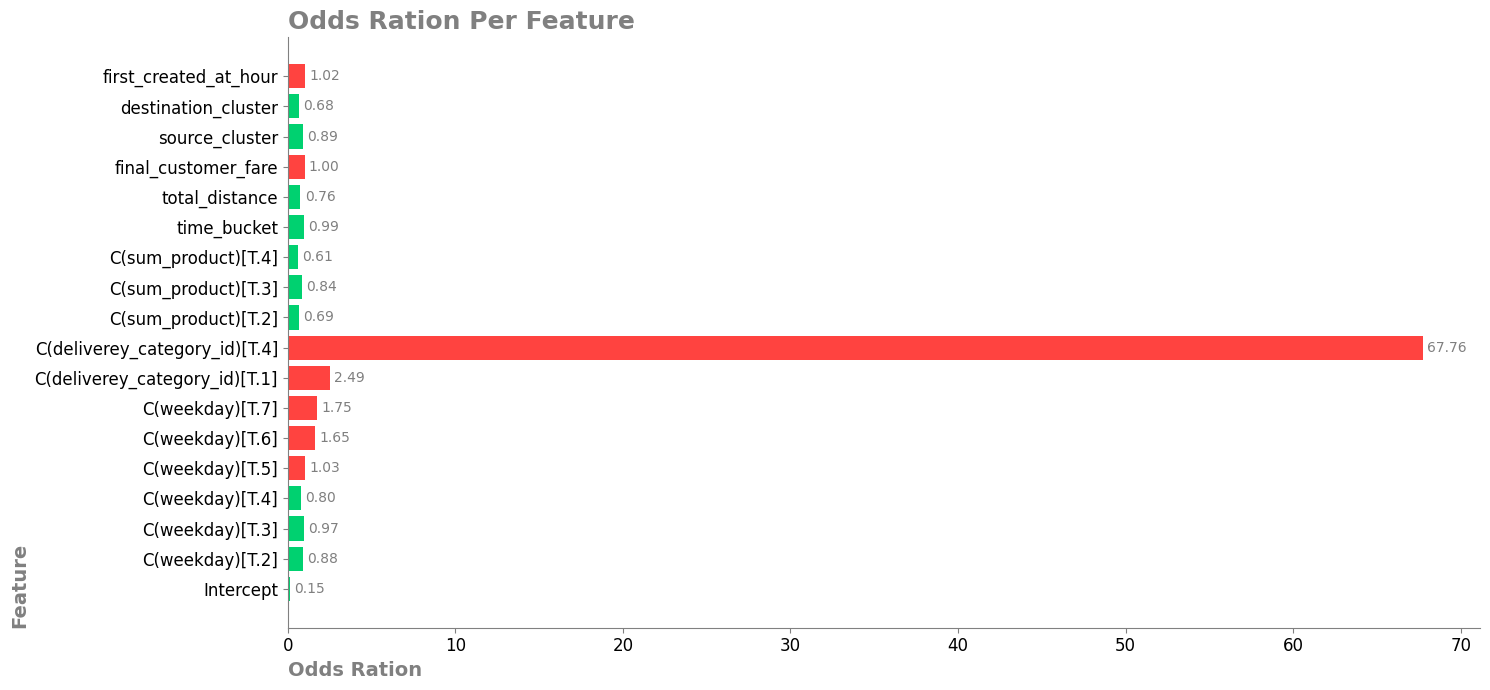

In [30]:
fig, ax= plt.subplots(figsize=(15, 7), sharex=True)

rect_share = ax.barh(
    odds_ratios.index,
    odds_ratios['odds_ratio'],
    color = np.where(odds_ratios['odds_ratio'].gt(1), "#FF4340", "#00D170")
)

ax.bar_label(rect_share, padding= 3, fmt="%.2f", alpha= 0.5)
ax.spines[["top", "right"]].set_visible(False)
ax.spines[["bottom", "left"]].set_color("gray")
ax.tick_params(axis="x", color= "gray", labelsize= "large")
ax.tick_params(axis="y", color= "gray", labelsize= "large")

ax.set_xlabel("Odds Ration", loc= "left", weight= "bold", fontsize= 14, color= "gray")

ax.set_ylabel(
    "Feature",
    loc = "bottom",
    weight= "bold",
    fontsize =14,
    color= "gray"
)

ax.set_title(
    "Odds Ration Per Feature",
    loc = "left",
    weight= "bold",
    fontsize =18,
    color= "gray"
)

plt.tight_layout()
plt.savefig(
    "D:\Data Science (bootcamp)\machine_learning\guided_project_machine_learning\order-delay-analysis/figure_pic/16_logistic_regression_analysis.png",
    dpi=300
            )
plt.show()

## Modeling

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    KBinsDiscretizer,
)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

In [32]:
orders_features.head()

,created_date,deliverey_category_id,weekday,first_created_at,time_bucket,total_distance,sum_product,final_customer_fare,final_biker_fare,first_customer_fare,hyper_ack,first_created_at_hour,destination_cluster,source_cluster
0,2022-07-25,0,1,2022-07-25 15:34:22+00:00,120,4.4780,17,300000,300000,250000,1,15,1,2
1,2022-07-23,0,6,2022-07-23 10:21:51+00:00,89,3.3368,5,470000,470000,230000,1,10,2,1
2,2022-10-16,0,7,2022-10-16 10:27:08+00:00,83,0.4854,1,160000,160000,160000,1,10,1,2
3,2022-10-25,4,2,2022-10-25 09:57:54+00:00,80,8.1736,1,950000,530000,530000,1,9,1,2
4,2022-08-01,0,1,2022-08-01 08:48:47+00:00,79,2.4995,1,450000,360000,230000,1,8,0,0


In [33]:
numerical_cols = [
    "time_bucket", 
    "total_distance",
    "first_created_at_hour",
    "final_customer_fare",
]

categorical_cols = [
    "deliverey_category_id",
    "weekday",
    "destination_cluster",
    "source_cluster",
]

ordinal_catergory_cols = ["sum_product"]

In [34]:
num_pipeline = Pipeline(
    steps=[("impute", SimpleImputer(strategy="mean")), ("scale", MinMaxScaler())]
)

ohe_cat_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        (
            "one-hot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype="int"),
        ),
    ]
)
oe_cat_pipeline = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        (
            "ordinal",
            KBinsDiscretizer(
                n_bins=4, encode="ordinal", strategy="quantile"
            ),
        ),
    ]   
)

In [35]:
from sklearn.compose import ColumnTransformer

col_trans = ColumnTransformer(
    transformers=[
        ("num_pipeline", num_pipeline, numerical_cols),
        ("ohe_cat_pipeline", ohe_cat_pipeline, categorical_cols),
        ("oe_cat_pipeline", oe_cat_pipeline, ordinal_catergory_cols),
    ],
    remainder="drop",
    n_jobs=-1,
)
feature_selector = Pipeline(steps=[("feat_selector", SelectKBest(chi2))])

In [36]:
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression(random_state=0)
log_reg_clf_pipeline = Pipeline(
    steps=[
        ("col_trans", col_trans),
        ("selector", feature_selector),
        ("model", log_reg_clf),
    ]
)

In [37]:
from sklearn import set_config

set_config(display="diagram")
display(log_reg_clf_pipeline)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['time_bucket',
                                                   'total_distance',
                                                   'first_created_at_hour',
                                                   'final_customer_fare']),
                                                 ('ohe_cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(d...
                                                   'destination_cluster',
                                                   'source_cluster']),
                                                 ('oe_cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=4))]),
                                                  ['sum_product'])])),
                ('selector',
                 Pipeline(steps=[('feat_selector',
                                  SelectKBest(score_func=<function chi2 at 0x000002D6A26EACA0>))])),
                ('model', LogisticRegression(random_state=0))])

In [38]:
from sklearn.model_selection import train_test_split

X = orders_features[numerical_cols + categorical_cols + ordinal_catergory_cols]
y = orders_features["hyper_ack"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [39]:
log_reg_clf_pipeline.fit(X_train, y_train)
# preds = log_reg_clf_pipeline.predict(X_test)
score = log_reg_clf_pipeline.score(X_valid, y_valid)
print(f"Model score: {score}")

Model score: 0.8561151079136691


In [40]:
param_grid_logistic_regression = {
    "model__penalty": ["l1", "l2"],
    "model__C": np.logspace(-4, 4, 20),
    "model__solver": ["liblinear"],
}

In [41]:
from sklearn.model_selection import GridSearchCV

grid_search_logistic_regression = GridSearchCV(
    log_reg_clf_pipeline,
    param_grid= param_grid_logistic_regression,
    cv = 5,
    scoring="accuracy",
    verbose=True,
    n_jobs=-1,
)

In [42]:
grid_search_logistic_regression.fit(X_train, y_train)

print("Best score of train set: " + str(grid_search_logistic_regression.best_score_))
print("Best parameter set: " + str(grid_search_logistic_regression.best_params_))
print("Test score: " + str(grid_search_logistic_regression.score(X_valid, y_valid)))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best score of train set: 0.8701368484082828
Best parameter set: {'model__C': 206.913808111479, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Test score: 0.8705035971223022


In [43]:
y_pred_logistic = grid_search_logistic_regression.best_estimator_.predict(X_valid)

In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_log = precision_score(y_valid, y_pred_logistic)
recall_log = recall_score(y_valid, y_pred_logistic)
f1_log = f1_score(y_valid, y_pred_logistic)

print(f"Precision score: {precision_log:.3f}")
print(f"recall score: {recall_log:.3f}")
print(f"F_1 score: {f1_log:.3f}")



Precision score: 0.921
recall score: 0.790
F_1 score: 0.851


In [45]:
from sklearn.metrics import confusion_matrix

confusion_matrix_logistic = confusion_matrix(y_valid, y_pred_logistic)

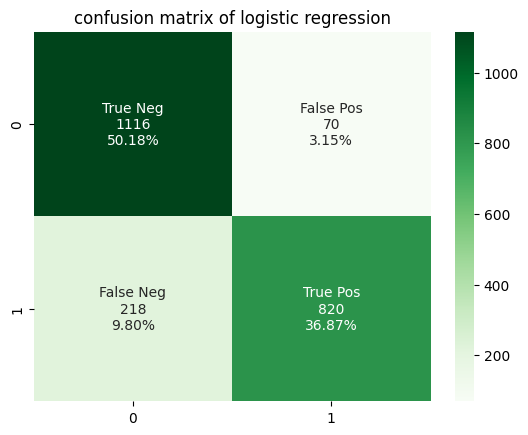

In [46]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = [
    "{0:0.0f}".format(value) for value in confusion_matrix_logistic.flatten()
]
group_percentages = [
    "{0:0.2%}".format(value)
    for value in confusion_matrix_logistic.flatten() / np.sum(confusion_matrix_logistic)
]
labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix_logistic, annot=labels, fmt="", cmap="Greens")
plt.title("confusion matrix of logistic regression")
plt.show()

In [47]:
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier(random_state=0)
xgboost_clf_pipeline = Pipeline(
    steps=[
        ("col_trans", col_trans),
        ("model", xgboost_clf),
    ]
)

In [48]:
set_config(display="diagram")
display(xgboost_clf_pipeline)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['time_bucket',
                                                   'total_distance',
                                                   'first_created_at_hour',
                                                   'final_customer_fare']),
                                                 ('ohe_cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(d...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

In [49]:
xgboost_clf_pipeline.fit(X_train, y_train)

score = xgboost_clf_pipeline.score(X_valid, y_valid)
print(f"Model score: {score}")

Model score: 0.8866906474820144


In [52]:
xgb_param_grid = {
    "model__learning_rate": np.arange(0.05, 1, 0.05),
    "model__max_depth": np.arange(3, 7, 1),
    "model__n_estimators": np.arange(50, 200, 50),
}

In [54]:
grid_search_xgb = GridSearchCV(
    xgboost_clf_pipeline,
    param_grid= xgb_param_grid,
    cv=5,
    scoring="roc_auc",
    verbose=True,
    n_jobs=-1,
)

In [56]:
grid_search_xgb.fit(X_train, y_train)

print("Best score of train set: " + str(grid_search_xgb.best_score_))
print("Best parameter set: " + str(grid_search_xgb.best_params_))
print("Test score: " + str(grid_search_xgb.score(X_valid, y_valid)))

Fitting 5 folds for each of 228 candidates, totalling 1140 fits
Best score of train set: 0.9455567794037851
Best parameter set: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 50}
Test score: 0.9496177302959705


In [58]:
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_valid)

In [60]:
precision_xgb = precision_score(y_valid, y_pred_xgb)
recall_xgb = recall_score(y_valid, y_pred_xgb)
f1_xgb = f1_score(y_valid, y_pred_xgb)

print(f"Precision score: {precision_xgb:.3f}")
print(f"recall score: {recall_xgb:.3f}")
print(f"F_1 score: {f1_xgb:.3f}")

Precision score: 0.904
recall score: 0.866
F_1 score: 0.884


In [65]:
confusion_matrix_xgb = confusion_matrix(y_valid, y_pred_xgb)

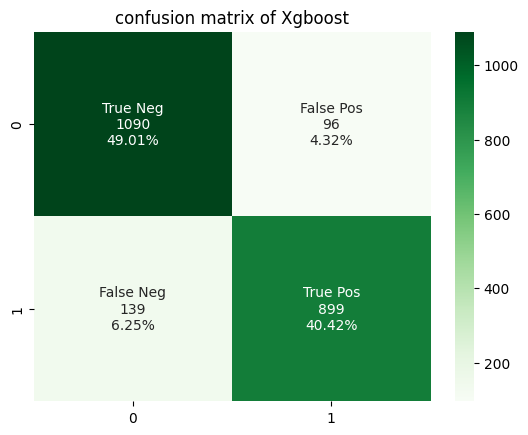

In [66]:
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = [
    "{0:0.0f}".format(value) for value in confusion_matrix_xgb.flatten()
]
group_percentages = [
    "{0:0.2%}".format(value)
    for value in confusion_matrix_xgb.flatten() / np.sum(confusion_matrix_logistic)
]
labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix_xgb, annot=labels, fmt="", cmap="Greens")
plt.title("confusion matrix of Xgboost")
plt.show()

In [67]:
joblib.dump(
    grid_search_xgb.best_estimator_,
    "../model/classification_pipeline.joblib"
)

['../model/classification_pipeline.joblib']